In [1]:
import pickle
import numpy as np
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
import wandb
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
import joblib
from sklearn.multioutput import MultiOutputRegressor

from data_work import *
from FFNN_class import *
from call import *
from loss_class import *

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vbalmer (v-balmer). Use `wandb login --relogin` to force relogin


True

In [3]:
## 0 - Read in the data

path = os.getcwd()
name = 'data\data_20240823_1752_case4'
path_data = os.path.join(path, name)

# Get sig, eps data
new_data_eps_np = read_data(path_data, 'eps')           # if augmented data set: use 'eps_add', etc.
new_data_sig_np = read_data(path_data, 'sig')           # if augmented data set: use 'sig_add', etc.
amt_data_points = new_data_sig_np.shape[0]

# Adjust sig to units required for simulation: [Nmm/mm] instead of [kNm/m]
new_data_sig_np[:,3:6] = new_data_sig_np[:,3:6]*10**3
# Adjust sig to units required for NN training: [MN, cm] instead of [N, mm] (240813_UpdateMeeting_1, ~slide 9)
# will be reversed after prediction of D, sig
new_data_sig_np = transf_units(new_data_sig_np, 'sig', forward = True)
new_data_inp = new_data_eps_np
new_data_out = new_data_sig_np


# Additional input variables (here: t)
new_data_t_np = read_data(path_data, 't')
new_data_inp = np.concatenate((new_data_eps_np, new_data_t_np),1)
new_data_inp= transf_units(new_data_inp, 'eps-t', forward = True)
# Additional variable in labels: D, used for sobolev loss if indicated, and for checking in deployment
new_data_De_np = read_data(path_data, 'De')
new_data_De_np = transf_units(new_data_De_np.reshape((amt_data_points, 8, 8)), 'D', forward = True)     #change units
new_data_De_np = new_data_De_np.reshape((amt_data_points, 64))
new_data_out = np.concatenate((new_data_sig_np, new_data_De_np),1)

# Select amount of bins
nbins = 50

print('Total amount of data points:', amt_data_points)

Total amount of data points: 4680


In [4]:
# 1 Train-Eval-Test Split 
# for train-eval-test = 0.7 - 0.2 - 0.1

# Split into aux and test
X_aux, X_test, y_aux, y_test = train_test_split(new_data_inp,new_data_out, test_size=0.1, random_state=42)

# Split into train and eval
X_train, X_eval, y_train, y_eval = train_test_split(new_data_inp,new_data_out, test_size=0.222, random_state=42)

# Save split data
save_path = os.path.join(path, 'new_data')
save_data(X_train, X_eval, X_test, y_train, y_eval, y_test, save_path)

# Plot to check
# histogram(X_train[:,0:8], y_train[:,0:8], amt_data_points, nbins, 'eps')
# histogram(X_train[:,0:8], y_train[:,0:8], amt_data_points, nbins, 'sig')
# histogram(X_train[:,8], y_train[:,0:8], amt_data_points, nbins, 't')
# histogram(X_eval[:,0:8], y_eval[:,0:8], amt_data_points, nbins, 'eps')
# histogram(X_eval[:,0:8], y_eval[:,0:8], amt_data_points, nbins, 'sig')
# histogram(X_eval[:,8], y_eval[:,0:8], amt_data_points, nbins, 't')
# histogram(X_test[:,0:8], y_test[:,0:8], amt_data_points, nbins, 'eps')
# histogram(X_test[:,0:8], y_test[:,0:8], amt_data_points, nbins, 'sig')
# histogram(X_test[:,8], y_test[:,0:8], amt_data_points, nbins, 't')

In [5]:
## 2 - Normalisation

stats_X_train = statistics(X_train)
stats_y_train = statistics(y_train)
stats_X_eval = statistics(X_eval)
stats_y_eval = statistics(y_eval)
stats_X_test = statistics(X_test)
stats_y_test = statistics(y_test)

# print(stats_y_train['std'])

X_train_t = transform_data(X_train, stats_X_train, forward=True)
y_train_t = transform_data(y_train, stats_y_train, forward=True)
X_eval_t = transform_data(X_eval, stats_X_eval, forward=True)
y_eval_t = transform_data(y_eval, stats_y_eval, forward=True)
X_test_t = transform_data(X_test, stats_X_test, forward=True)
y_test_t = transform_data(y_test, stats_y_test, forward=True)

mat_data_stats = {'stats_X_train': stats_X_train,
                  'stats_y_train': stats_y_train,
                  'stats_X_test': stats_X_test,
                  'stats_y_test': stats_y_test
                  }

with open(os.path.join(save_path, 'mat_data_stats.pkl'), 'wb') as fp:
        pickle.dump(mat_data_stats, fp)

# Check for nan
# has_nan_train = np.isnan(y_train_t).any()
# has_nan_eval = np.isnan(y_eval_t).any()
# has_nan_test = np.isnan(y_test_t).any()
# print('train, eval, test: ', has_nan_train, has_nan_eval, has_nan_test)
# print('If all are false: No nan is in data set')

# Plot to check
# histogram(X_train_t[:,0:8], y_train_t[:,0:8], amt_data_points, nbins, 'eps')
# histogram(X_train_t[:,0:8], y_train_t[:,0:8], amt_data_points, nbins, 'sig')
# histogram(X_train_t[:,8], y_train_t[:,0:8], amt_data_points, nbins, 't')
# histogram(X_eval_t[:,0:8], y_eval_t[:,0:8], amt_data_points, nbins, 'eps')
# histogram(X_eval_t[:,0:8], y_eval_t[:,0:8], amt_data_points, nbins, 'sig')
# histogram(X_eval_t[:,8], y_eval_t[:,0:8], amt_data_points, nbins, 't')
# histogram(X_test_t[:,0:8], y_test_t[:,0:8], amt_data_points, nbins, 'eps')
# histogram(X_test_t[:,0:8], y_test_t[:,0:8], amt_data_points, nbins, 'sig')
# histogram(X_test_t[:,8], y_test_t[:,0:8], amt_data_points, nbins, 't')

In [6]:
## 3 - Set hyperparameters for xgboost and create instance of model

inp = {
    'random_state': 42,
    'fourier_mapping': False,
    'max_depth': 25,
    'learning_rate': 0.001,
    'objective': 'reg:squarederror',
    'eval_metric': ['rmse'],
    'n_estimators': 1000,
    'num_parallel_tree': 1,
}

# logging input parameters for wandb
run = wandb.init(
        project = 'ShellSim_XGBoost_v0',
        config = {
                "random_state": inp['random_state'],
                'fourier_mapping': inp['fourier_mapping'],
                'max_depth': inp['max_depth'],
                'learning_rate': inp['learning_rate'],
                'objective': inp['objective'],
                'eval_metric': inp['eval_metric'],
                'n_estimators': inp['n_estimators'],
                'num_parallel_tree': inp['num_parallel_tree']
        },
)

n_labels = 8
models = {}

for i in range(n_labels):
        model = xgb.XGBRegressor(verbosity = 1, random_state = inp['random_state'], 
                                feature_selector='greedy',
                                max_depth = inp['max_depth'], 
                                learning_rate = inp['learning_rate'],
                                objective = inp['objective'], 
                                eval_metric = inp['eval_metric'],
                                n_estimators = inp['n_estimators'], 
                                num_parallel_tree = int(inp['num_parallel_tree']))
        model.fit(X_train_t, y_train_t[:,i], 
                  eval_set=[(X_eval_t, y_eval_t[:,i])])
        models[f'model_{i}'] = model
# xgb_reg_mult = MultiOutputRegressor(xgb_reg)
# print(xgb_reg_mult)

# save inp to file
with open(os.path.join(save_path, 'inp.pkl'), 'wb') as fp:
        pickle.dump(inp, fp)



[0]	validation_0-rmse:0.99910
[1]	validation_0-rmse:0.99821
[2]	validation_0-rmse:0.99731
[3]	validation_0-rmse:0.99642
[4]	validation_0-rmse:0.99552
[5]	validation_0-rmse:0.99463
[6]	validation_0-rmse:0.99374
[7]	validation_0-rmse:0.99285
[8]	validation_0-rmse:0.99196
[9]	validation_0-rmse:0.99107
[10]	validation_0-rmse:0.99018


C:\Users\vbalmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [16:45:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_selector" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-rmse:0.98929
[12]	validation_0-rmse:0.98841
[13]	validation_0-rmse:0.98752
[14]	validation_0-rmse:0.98664
[15]	validation_0-rmse:0.98576
[16]	validation_0-rmse:0.98487
[17]	validation_0-rmse:0.98399
[18]	validation_0-rmse:0.98311
[19]	validation_0-rmse:0.98223
[20]	validation_0-rmse:0.98135
[21]	validation_0-rmse:0.98048
[22]	validation_0-rmse:0.97960
[23]	validation_0-rmse:0.97873
[24]	validation_0-rmse:0.97785
[25]	validation_0-rmse:0.97698
[26]	validation_0-rmse:0.97611
[27]	validation_0-rmse:0.97524
[28]	validation_0-rmse:0.97436
[29]	validation_0-rmse:0.97350
[30]	validation_0-rmse:0.97263
[31]	validation_0-rmse:0.97177
[32]	validation_0-rmse:0.97091
[33]	validation_0-rmse:0.97005
[34]	validation_0-rmse:0.96919
[35]	validation_0-rmse:0.96833
[36]	validation_0-rmse:0.96747
[37]	validation_0-rmse:0.96661
[38]	validation_0-rmse:0.96575
[39]	validation_0-rmse:0.96490
[40]	validation_0-rmse:0.96404
[41]	validation_0-rmse:0.96319
[42]	validation_0-rmse:0.96233
[43]	val

C:\Users\vbalmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [16:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_selector" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-rmse:0.99491
[6]	validation_0-rmse:0.99406
[7]	validation_0-rmse:0.99322
[8]	validation_0-rmse:0.99237
[9]	validation_0-rmse:0.99153
[10]	validation_0-rmse:0.99069
[11]	validation_0-rmse:0.98985
[12]	validation_0-rmse:0.98901
[13]	validation_0-rmse:0.98817
[14]	validation_0-rmse:0.98733
[15]	validation_0-rmse:0.98650
[16]	validation_0-rmse:0.98566
[17]	validation_0-rmse:0.98483
[18]	validation_0-rmse:0.98399
[19]	validation_0-rmse:0.98316
[20]	validation_0-rmse:0.98232
[21]	validation_0-rmse:0.98149
[22]	validation_0-rmse:0.98066
[23]	validation_0-rmse:0.97983
[24]	validation_0-rmse:0.97900
[25]	validation_0-rmse:0.97817
[26]	validation_0-rmse:0.97735
[27]	validation_0-rmse:0.97652
[28]	validation_0-rmse:0.97569
[29]	validation_0-rmse:0.97487
[30]	validation_0-rmse:0.97404
[31]	validation_0-rmse:0.97322
[32]	validation_0-rmse:0.97240
[33]	validation_0-rmse:0.97157
[34]	validation_0-rmse:0.97075
[35]	validation_0-rmse:0.96993
[36]	validation_0-rmse:0.96912
[37]	validati

C:\Users\vbalmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [16:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_selector" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-rmse:0.99457
[6]	validation_0-rmse:0.99367
[7]	validation_0-rmse:0.99277
[8]	validation_0-rmse:0.99187
[9]	validation_0-rmse:0.99097
[10]	validation_0-rmse:0.99007
[11]	validation_0-rmse:0.98917
[12]	validation_0-rmse:0.98828
[13]	validation_0-rmse:0.98738
[14]	validation_0-rmse:0.98649
[15]	validation_0-rmse:0.98559
[16]	validation_0-rmse:0.98470
[17]	validation_0-rmse:0.98381
[18]	validation_0-rmse:0.98291
[19]	validation_0-rmse:0.98202
[20]	validation_0-rmse:0.98113
[21]	validation_0-rmse:0.98025
[22]	validation_0-rmse:0.97936
[23]	validation_0-rmse:0.97847
[24]	validation_0-rmse:0.97759
[25]	validation_0-rmse:0.97674
[26]	validation_0-rmse:0.97590
[27]	validation_0-rmse:0.97502
[28]	validation_0-rmse:0.97418
[29]	validation_0-rmse:0.97334
[30]	validation_0-rmse:0.97246
[31]	validation_0-rmse:0.97163
[32]	validation_0-rmse:0.97080
[33]	validation_0-rmse:0.96992
[34]	validation_0-rmse:0.96910
[35]	validation_0-rmse:0.96823
[36]	validation_0-rmse:0.96740
[37]	validati

C:\Users\vbalmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [16:46:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_selector" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:0.99937
[1]	validation_0-rmse:0.99873
[2]	validation_0-rmse:0.99810
[3]	validation_0-rmse:0.99747
[4]	validation_0-rmse:0.99685
[5]	validation_0-rmse:0.99622
[6]	validation_0-rmse:0.99559
[7]	validation_0-rmse:0.99497
[8]	validation_0-rmse:0.99435
[9]	validation_0-rmse:0.99373
[10]	validation_0-rmse:0.99310
[11]	validation_0-rmse:0.99249
[12]	validation_0-rmse:0.99187
[13]	validation_0-rmse:0.99125
[14]	validation_0-rmse:0.99064
[15]	validation_0-rmse:0.99002
[16]	validation_0-rmse:0.98941
[17]	validation_0-rmse:0.98880
[18]	validation_0-rmse:0.98819
[19]	validation_0-rmse:0.98758
[20]	validation_0-rmse:0.98697
[21]	validation_0-rmse:0.98636
[22]	validation_0-rmse:0.98576
[23]	validation_0-rmse:0.98515
[24]	validation_0-rmse:0.98455
[25]	validation_0-rmse:0.98394
[26]	validation_0-rmse:0.98334
[27]	validation_0-rmse:0.98274
[28]	validation_0-rmse:0.98215
[29]	validation_0-rmse:0.98155
[30]	validation_0-rmse:0.98095
[31]	validation_0-rmse:0.98036
[32]	validation_0-

C:\Users\vbalmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [16:47:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_selector" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-rmse:0.99457
[9]	validation_0-rmse:0.99397
[10]	validation_0-rmse:0.99337
[11]	validation_0-rmse:0.99278
[12]	validation_0-rmse:0.99218
[13]	validation_0-rmse:0.99159
[14]	validation_0-rmse:0.99100
[15]	validation_0-rmse:0.99040
[16]	validation_0-rmse:0.98981
[17]	validation_0-rmse:0.98922
[18]	validation_0-rmse:0.98863
[19]	validation_0-rmse:0.98805
[20]	validation_0-rmse:0.98746
[21]	validation_0-rmse:0.98688
[22]	validation_0-rmse:0.98630
[23]	validation_0-rmse:0.98571
[24]	validation_0-rmse:0.98513
[25]	validation_0-rmse:0.98454
[26]	validation_0-rmse:0.98396
[27]	validation_0-rmse:0.98337
[28]	validation_0-rmse:0.98279
[29]	validation_0-rmse:0.98220
[30]	validation_0-rmse:0.98162
[31]	validation_0-rmse:0.98104
[32]	validation_0-rmse:0.98046
[33]	validation_0-rmse:0.97988
[34]	validation_0-rmse:0.97931
[35]	validation_0-rmse:0.97872
[36]	validation_0-rmse:0.97814
[37]	validation_0-rmse:0.97757
[38]	validation_0-rmse:0.97699
[39]	validation_0-rmse:0.97643
[40]	valid

C:\Users\vbalmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [16:47:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_selector" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:0.99521
[7]	validation_0-rmse:0.99454
[8]	validation_0-rmse:0.99387
[9]	validation_0-rmse:0.99319
[10]	validation_0-rmse:0.99252
[11]	validation_0-rmse:0.99187
[12]	validation_0-rmse:0.99120
[13]	validation_0-rmse:0.99055
[14]	validation_0-rmse:0.98989
[15]	validation_0-rmse:0.98924
[16]	validation_0-rmse:0.98860
[17]	validation_0-rmse:0.98796
[18]	validation_0-rmse:0.98733
[19]	validation_0-rmse:0.98669
[20]	validation_0-rmse:0.98606
[21]	validation_0-rmse:0.98543
[22]	validation_0-rmse:0.98479
[23]	validation_0-rmse:0.98417
[24]	validation_0-rmse:0.98354
[25]	validation_0-rmse:0.98292
[26]	validation_0-rmse:0.98230
[27]	validation_0-rmse:0.98167
[28]	validation_0-rmse:0.98105
[29]	validation_0-rmse:0.98043
[30]	validation_0-rmse:0.97982
[31]	validation_0-rmse:0.97921
[32]	validation_0-rmse:0.97859
[33]	validation_0-rmse:0.97797
[34]	validation_0-rmse:0.97736
[35]	validation_0-rmse:0.97675
[36]	validation_0-rmse:0.97614
[37]	validation_0-rmse:0.97553
[38]	validat

C:\Users\vbalmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [16:48:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_selector" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-rmse:0.99067
[10]	validation_0-rmse:0.98975
[11]	validation_0-rmse:0.98882
[12]	validation_0-rmse:0.98789
[13]	validation_0-rmse:0.98697
[14]	validation_0-rmse:0.98605
[15]	validation_0-rmse:0.98512
[16]	validation_0-rmse:0.98420
[17]	validation_0-rmse:0.98328
[18]	validation_0-rmse:0.98236
[19]	validation_0-rmse:0.98144
[20]	validation_0-rmse:0.98053
[21]	validation_0-rmse:0.97961
[22]	validation_0-rmse:0.97870
[23]	validation_0-rmse:0.97778
[24]	validation_0-rmse:0.97687
[25]	validation_0-rmse:0.97596
[26]	validation_0-rmse:0.97504
[27]	validation_0-rmse:0.97414
[28]	validation_0-rmse:0.97322
[29]	validation_0-rmse:0.97231
[30]	validation_0-rmse:0.97140
[31]	validation_0-rmse:0.97048
[32]	validation_0-rmse:0.96958
[33]	validation_0-rmse:0.96867
[34]	validation_0-rmse:0.96775
[35]	validation_0-rmse:0.96685
[36]	validation_0-rmse:0.96594
[37]	validation_0-rmse:0.96503
[38]	validation_0-rmse:0.96413
[39]	validation_0-rmse:0.96323
[40]	validation_0-rmse:0.96232
[41]	vali

C:\Users\vbalmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [16:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_selector" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-rmse:0.98483
[16]	validation_0-rmse:0.98389
[17]	validation_0-rmse:0.98296
[18]	validation_0-rmse:0.98202
[19]	validation_0-rmse:0.98107
[20]	validation_0-rmse:0.98014
[21]	validation_0-rmse:0.97919
[22]	validation_0-rmse:0.97826
[23]	validation_0-rmse:0.97731
[24]	validation_0-rmse:0.97638
[25]	validation_0-rmse:0.97545
[26]	validation_0-rmse:0.97451
[27]	validation_0-rmse:0.97358
[28]	validation_0-rmse:0.97264
[29]	validation_0-rmse:0.97172
[30]	validation_0-rmse:0.97079
[31]	validation_0-rmse:0.96986
[32]	validation_0-rmse:0.96894
[33]	validation_0-rmse:0.96801
[34]	validation_0-rmse:0.96709
[35]	validation_0-rmse:0.96617
[36]	validation_0-rmse:0.96525
[37]	validation_0-rmse:0.96433
[38]	validation_0-rmse:0.96340
[39]	validation_0-rmse:0.96249
[40]	validation_0-rmse:0.96157
[41]	validation_0-rmse:0.96065
[42]	validation_0-rmse:0.95974
[43]	validation_0-rmse:0.95882
[44]	validation_0-rmse:0.95791
[45]	validation_0-rmse:0.95699
[46]	validation_0-rmse:0.95608
[47]	val

In [7]:
## 4 -Train and evaluate model

# xgb_reg_mult.fit(X_train_t, y_train_t[:,0:8],
#                 eval_set = [(X_eval_t, y_eval_t[:,0:8])],
#                 verbose = False)
# print((xgb_reg_mult.predict(X_eval_t)-y_eval_t[:,0:8])**2)

# cv_scores = cross_val_score(xgb_reg, X_eval_t, y_eval_t[:,0:8], cv=5, scoring='neg_mean_squared_error')
# cv_rmse = np.sqrt(-cv_scores)

# print(f"Cross-Validation RMSE Scores: {cv_rmse}")
# print(f"Mean Cross-Validation RMSE: {cv_rmse.mean()}")

# xgb_reg_mult.predict(X_test)

In [8]:
## Save model

filename = 'trained_model.pkl'
joblib.dump(models, filename)
# joblib.dump(xgb_reg_mult, filename)

['trained_model.pkl']

Amount of test points 468


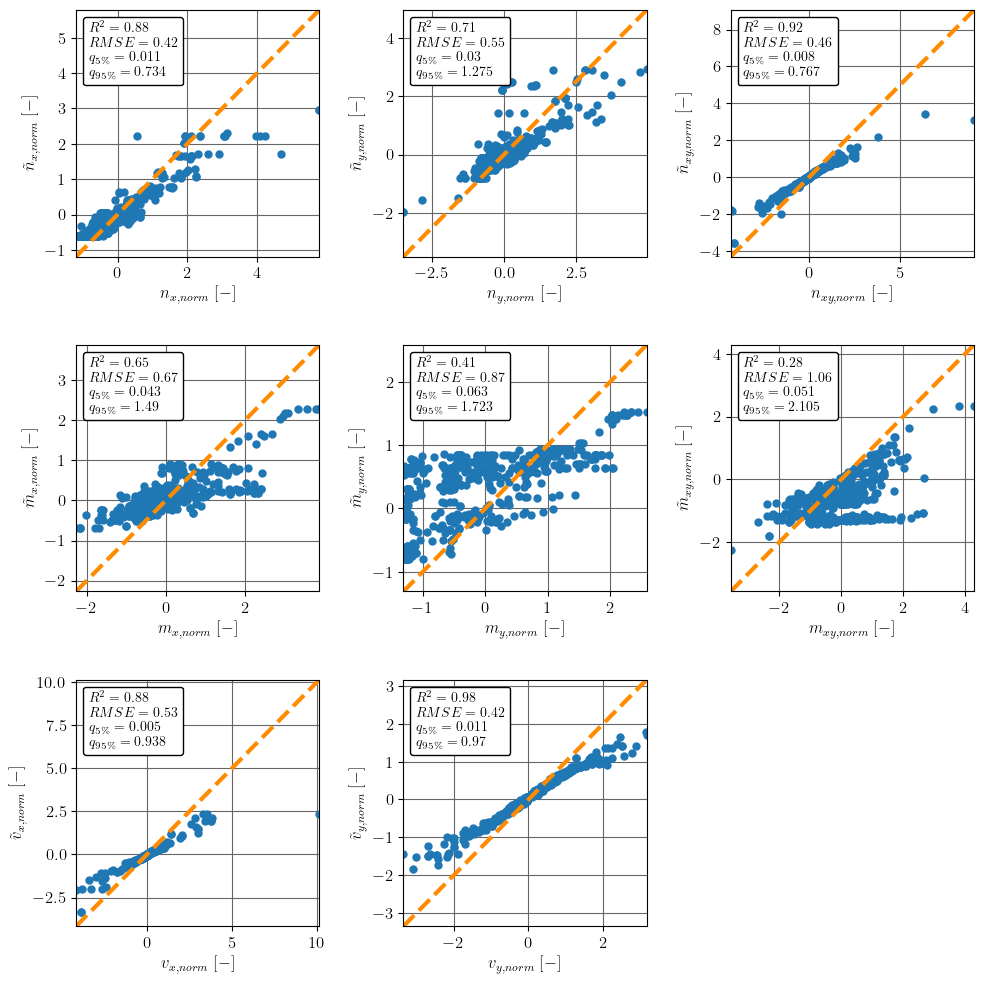

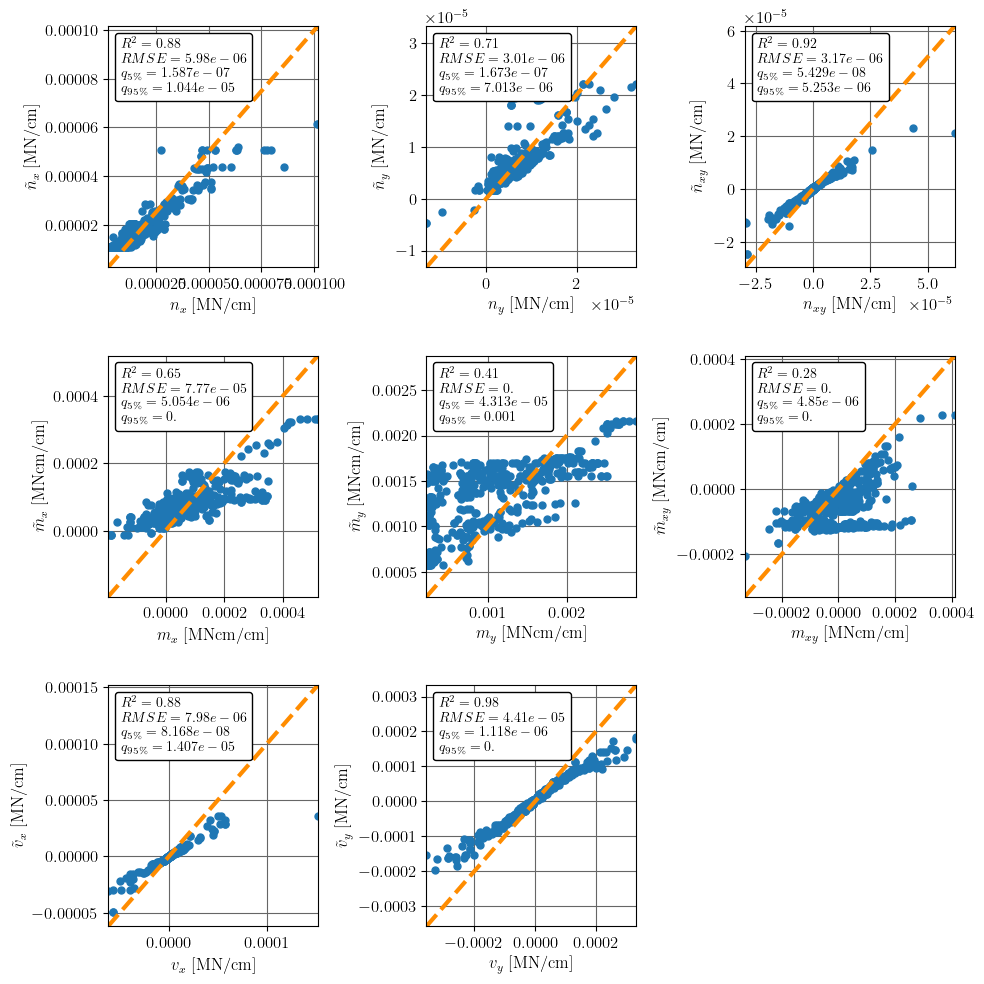

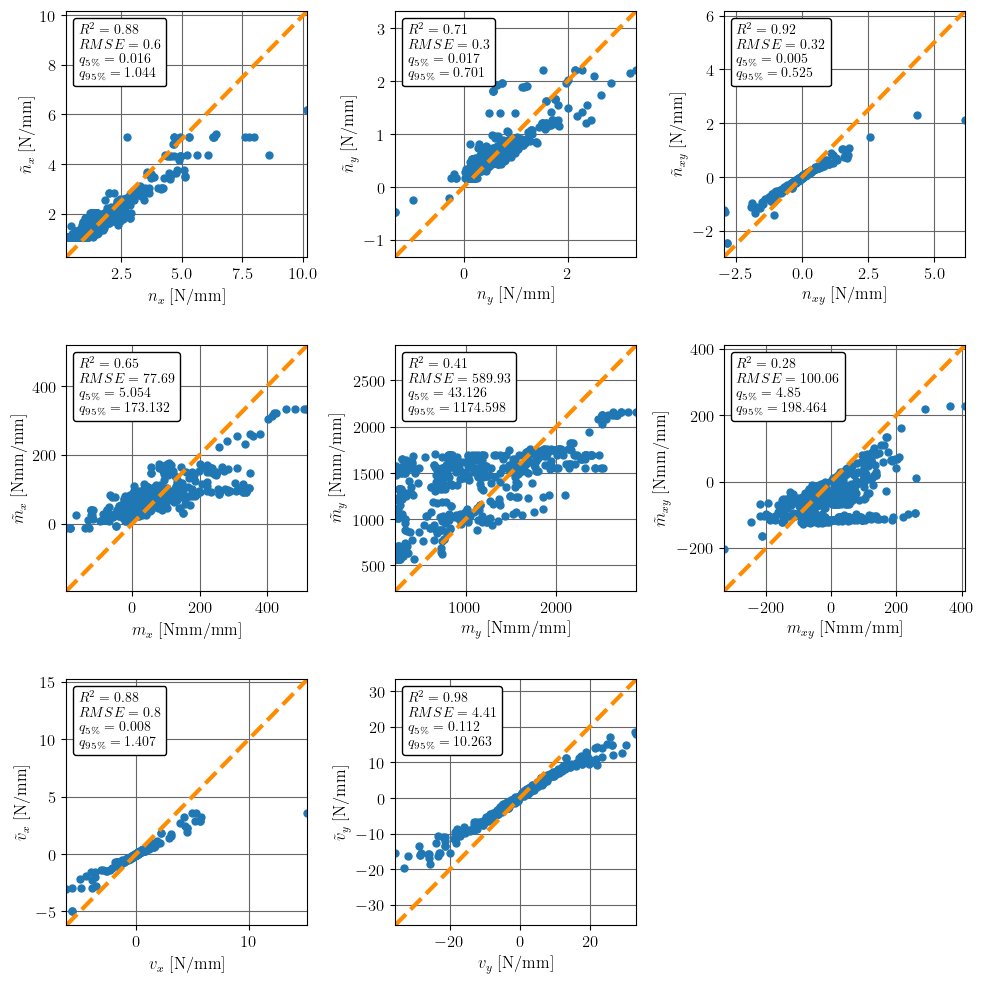

In [9]:
## 6 - Testing (45° plots for sigma)
## Note: This cell can also be run without running all above cells (except for importing libraries)

path = os.getcwd()
path_plots = os.path.join(path, 'plots')

# Load evaluated model
trained_model = joblib.load('trained_model.pkl')
data_model = load_data_model(path, only_test=False, XGBoost=True)

# Create predictions and transform to numpy
plot_data = predict_sig_XGB(data_model, trained_model)

# Create plots in normalised version
multiple_diagonal_plots(path_plots, plot_data['all_test_labels_t'], plot_data['all_predictions_t'], 't')
# multiple_diagonal_plots(path_plots, plot_data['all_test_labels_t'], xgb_reg_mult.predict(X_test_t), 't')

# Create plots in original scale (for improved mechanical understanding / interpretability)
multiple_diagonal_plots(path_plots, plot_data['all_test_labels'], plot_data['all_predictions'], 'o')

# Create plots in scale for simulation (N, mm for improved mechanical understanding / interpretability)
plot_data_label_u = transf_units(plot_data['all_test_labels'], 'sig', forward = False)
plot_data_pred_u = transf_units(plot_data['all_predictions'], 'sig', forward = False)
multiple_diagonal_plots(path_plots, plot_data_label_u, plot_data_pred_u, 'u')


# Create input-output plots for improved understanding
# data_train = np.concatenate((data_model['mat_data_np_TrainEvalTest']['X_train'][:,0:9], data_model['mat_data_np_TrainEvalTest']['y_train'][:,0:9]), axis = 1)
# inp_out_plt('eps_x', 'n_x', data_model, path, path_plots)       # for D_m_11
# inp_out_plt('eps_y', 'n_y', data_model, path, path_plots)       # for D_m_22
# inp_out_plt('eps_xy', 'n_xy', data_model, path, path_plots)     # for D_m_33
# inp_out_plt('chi_x', 'm_x', data_model, path, path_plots)       # for D_b_11
# inp_out_plt('gam_x', 'v_x', data_model, path, path_plots)       # for D_s_11
# inp_out_plt('chi_x', 'n_x', data_model, path, path_plots)       # for D_mb_11(1)


In [10]:
# 7 Testing - D-matrix

# make prediction of D (via derivatives)
plot_data_d = predict_D(data_model, stats_id = 'direct')

# MSE colorplot for all D
diff_sq = (plot_data_d['D_sim'].reshape((plot_data_d['D_sim'].shape[0], 64)) - plot_data_d['D_pred'].reshape((plot_data_d['D_pred'].shape[0], 64)))**2
MSE_D = np.mean((diff_sq), axis = 0)
RMSE_D = np.sqrt(MSE_D)
plt.imshow(MSE_D.reshape((8,8)), cmap = 'viridis')
plt.colorbar()


# diagonal plot for nonzero values of D 
multiple_diagonal_plots_Dnz(path_plots, plot_data_d['D_sim'], plot_data_d['D_pred'], 'o')

# diagonal plot for nonzero values of D (in correct units [N, mm])
plot_data_d_sim_u = transf_units(plot_data_d['D_sim'], 'D', forward = False)
plot_data_d_pred_u = transf_units(plot_data_d['D_pred'], 'D', forward = False)
multiple_diagonal_plots_Dnz(path_plots, plot_data_d_sim_u, plot_data_d_pred_u, 'u')

TypeError: 'NoneType' object is not iterable

In [11]:
# close wandb

wandb.finish()

In [ ]:
# if data should be saved to folder instead of being overwritten with the next simulation, use save_folder = True

from datetime import datetime
import shutil

save_folder = True

if save_folder:
    relative_path = ['new_data\\inp.pkl', 'new_data\\mat_data_np_TrainEvalTest.pkl', 'new_data\\mat_data_stats.pkl', 'new_data\\mat_data_TrainEvalTest.pkl',
                    'new_data\\trained_model.pt', 'new_data\\trained_model_best.pt']
    
    for i in range(len(relative_path)):
        source_folder = os.path.dirname(relative_path[i])
        file_name = os.path.basename(relative_path[i])

        current_time = datetime.now()
        new_folder = current_time.strftime("data_%Y%m%d_%H%M_case"+'xx')
        new_folder_path = os.path.join(source_folder, new_folder)

        os.makedirs(new_folder_path, exist_ok=True)

        destination_path = os.path.join(new_folder_path, file_name)
        shutil.copy(relative_path[i], destination_path)
        # also copy plots 
        shutil.copytree(os.path.join(os.getcwd(), 'plots'), new_folder_path, dirs_exist_ok=True)

        print('File', i, 'is copied to', destination_path)